# UB Correction

##   Reason: 
### UB based prediction interval computed in A3 is often wider than actual and have a higher coverage.
### The reason for this is:
#### a) Similar Samples are not the exactly same sample.
#### b) Considering silightly different samples those do not have an exact match. Say have 1% or 2% difference.
#### c) As a result the output distribution is more spread than the actual.
###   If we are setting UB_point =.90 in A3, we may get a point corresponds to near 0.96 cumulative probability.

###   Solving technique: 
#### 1. Getting effective UB for UB_points
#### 2. Train NN which takes effective UB and returns required  UB_points for that effective UB
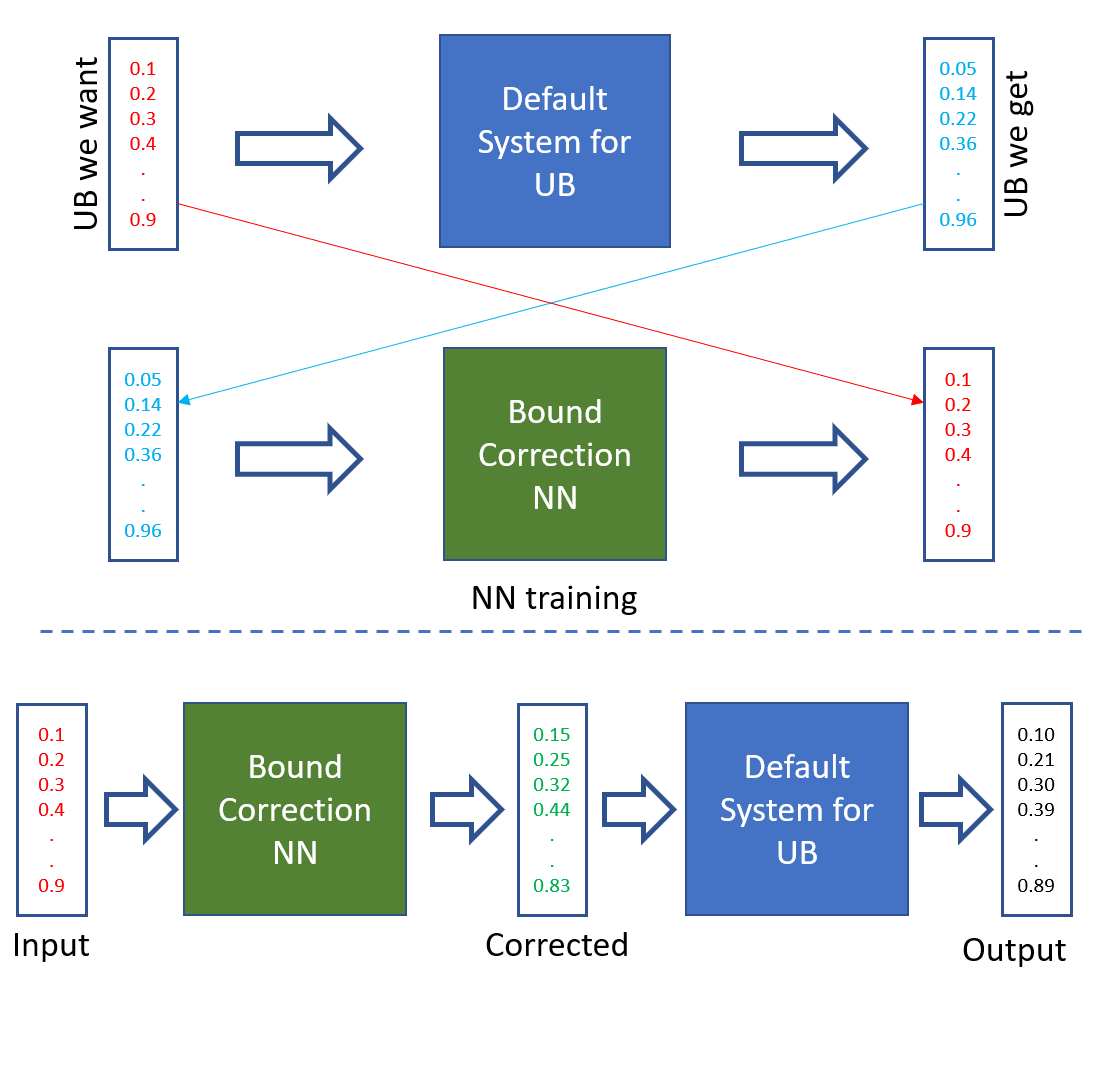

# Load Data

In [1]:
csv_path = '../input/life-expectancy-who-pre-process/Life_expectancy_last_column.csv'


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,Year,Adult Mortality,Infant Deaths,Alcohol,Expenditure(%),Hepatitis B,Measles,BMI,Under-five Deaths,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 Years,Thinness 5-9 Years,ICOR,Schooling,Life Expectancy
0,0,2015,263.0,62,0.01,71.279624,65.0,1154,19.1,83,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0
1,1,2014,271.0,64,0.01,73.523582,62.0,492,18.6,86,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9
2,2,2013,268.0,66,0.01,73.219243,64.0,430,18.1,89,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,3,2012,272.0,69,0.01,78.184215,67.0,2787,17.6,93,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5
4,4,2011,275.0,71,0.01,7.097109,68.0,3013,17.2,97,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2


In [2]:
import pickle as pkl

fileName =  '../input/a1-le-data-to-similar-events/Similarity'
fileObject2 = open(fileName, 'rb')
Imported_data = pkl.load(fileObject2)
fileObject2.close()

#print('Similarity Thresholds:',Imported_data[:,0])

#print('Most Similarity at:',Imported_data[:,1])

Similar_event_count = len(Imported_data[0,:])-1
print('Number of Similar Samples Considered', Similar_event_count)

Similarity_thresholds = Imported_data[:,0]

Sample_density = Similar_event_count/ Similarity_thresholds/100
#Sample_density = number of samples with less than 1% (of range) deviation

Similar_samples = Imported_data[:,1:Similar_event_count+1]

print('Target Shape', Sample_density.shape, 'Similar Samples Matrix Shape:', Similar_samples.shape)

input_=[]
output_=[]
for row in df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])

Number of Similar Samples Considered 100
Target Shape (1649,) Similar Samples Matrix Shape: (1649, 100)


# Finding UBs from the Default System

In [3]:
UB_we_get=[];
UB_we_want=[];

for UB_point in np.arange(0.01, 0.99, 0.01):
    higher_count=0;
    for iter1 in range(len(output_)):
        indexes=Similar_samples[iter1];
        Probability_density =[]
        for iter2 in indexes:
            Probability_density.append(output_[iter2.astype(np.int64)])
        Probability_density = np.sort(Probability_density)
        prediction_bound = Probability_density[np.round(Similar_event_count*UB_point).astype(np.int64)-1]
        if prediction_bound > output_[iter1]:
            higher_count = higher_count + 1;
    UB_we_get.append(higher_count/len(output_))
    UB_we_want.append(UB_point)
    #print('\n UBs',UB_we_get)
    #print(UB_we_want)
        

# Data Pre-processing for NN Training

In [4]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

x=[]
y=[]
i_val=[]
o_val=[]

for iter1 in range(len(UB_we_get)):
    if iter1%10==0:
        i_val.append(UB_we_get[iter1])
        o_val.append(UB_we_want[iter1])
        continue
    x.append(UB_we_get[iter1])
    y.append(UB_we_want[iter1])
            
    
x = torch.tensor(x).float()  
y = torch.tensor(y).float()   
new_shape = (len(y), 1)
x = x.view(new_shape)
y = y.view(new_shape)


i_val = torch.tensor(i_val).float()  
o_val = torch.tensor(o_val).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)
i_val = i_val.view(new_shape)

max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print(range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

tensor(0.9800) tensor(0.0200) tensor([0.9727]) tensor([0.0127])
tensor([0.9600]) tensor(0.9600)


# NN Training

In [5]:
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
 
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

num_input =1     
net = Net(n_feature=num_input, n_hidden=400, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


minimum_train_loss = 1e5
minimum_val_loss = 1e5
EPOCH = 600

# start training
for epoch in range(EPOCH):
  
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt = net
    
    if epoch%200 == 199:
        prediction = net_opt(i_val)
        loss_val = loss_func(prediction, o_val)
        if loss_val<minimum_val_loss:
            minimum_val_loss = loss_val
            net_opt_val = net_opt
        print ("Epoch [{}/{}], Loss: {:.4f}, Minimum Loss {:.6f}, Val Loss {:.6f}  "  .format(epoch+1, EPOCH, loss, minimum_train_loss, minimum_val_loss))

Net(
  (hidden): Linear(in_features=1, out_features=400, bias=True)
  (hidden2): Linear(in_features=400, out_features=400, bias=True)
  (predict): Linear(in_features=400, out_features=1, bias=True)
)
Epoch [200/600], Loss: 0.0000, Minimum Loss 0.000031, Val Loss 0.000031  
Epoch [400/600], Loss: 0.0000, Minimum Loss 0.000027, Val Loss 0.000026  
Epoch [600/600], Loss: 0.0000, Minimum Loss 0.000024, Val Loss 0.000023  


# Saving Trained NN

In [6]:
PATH = "./best_model.pt"
torch.save(net_opt_val.state_dict(), PATH)


'''
#Guideline for loading model in future 
net_load = Net(n_feature=num_input, n_hidden=400, n_output=1)     # define the network
net_load = net_load.to(device)

net_load.load_state_dict(torch.load(PATH, map_location=device))

'''

# saving limits
f = open('max_y.pckl', 'wb')
pkl.dump(max_y, f) 
f.close()

f = open('min_y.pckl', 'wb')
pkl.dump(min_y, f)
f.close()

f = open('max_x.pckl', 'wb')
pkl.dump(max_x.values, f) 
f.close()

f = open('min_x.pckl', 'wb')
pkl.dump(min_x.values, f)
f.close()

'''
# Test loading
f = open('min_x.pckl', 'rb')
obj = pkl.load(f)
f.close()

print(max_y, min_y, max_x.values, min_x.values)
print(obj)
'''

"\n# Test loading\nf = open('min_x.pckl', 'rb')\nobj = pkl.load(f)\nf.close()\n\nprint(max_y, min_y, max_x.values, min_x.values)\nprint(obj)\n"